In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../../..'))

if module_path not in sys.path:
    print(f"Adding [{module_path}] to sys.path")
    sys.path.append(module_path)

# Comparing ALCS Latent-Learning capabilities

Approach to compare *latent-learning* capabilities of various ALCS systems.

The following aspects will be compared:

- ability learn consequences of performing action in certain states (build accurate internal model of the environment),
- ability to generalize,
- size of internal classifier population,
- relative operation time

In [2]:
import pathlib

import matplotlib as mpl
import matplotlib.pyplot as plt


from lcs import Perception

import gym
# noinspection PyUnresolvedReferences
import gym_yacs_simple_maze
# noinspection PyUnresolvedReferences
import gym_corridor
# noinspection PyUnresolvedReferences
import gym_grid
# noinspection PyUnresolvedReferences
import gym_multiplexer

# Logger
# import logging
# logging.basicConfig(level=logging.DEBUG)

# Common plot settings
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['lines.linewidth'] = 2

# Gecco submission settings
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2

In [3]:
from notebooks import get_from_cache_or_run

# Import common utils code
%run utils/experiments.py
%run utils/plotting.py

In [4]:
cache_prefix = f'{pathlib.Path().absolute()}/cache/'
cache_prefix

'/home/arc/Projects/pwr/pyalcs-experiments/notebooks/publications/latent-learning-for-anticipatory-classifier-systems-in-discretized-real-valued-environments/cache/'

# Environments
This section presents the multi-step environments that were used in experiments.

1. [Simple Maze](#Simple-Maze) - Simpler maze variant with limited perception and available actions

Discretized real-valued.

2. [Corridor](#Corridor) - one dimension and two actions are available. The agent is checked is optimal number of classifiers is created
3. [Grid](#Grid) - two dimensions and four actions.

Maybe (todo)

4. Maze4 / Maze6 - More advanced mazes (bigger perception and available actions)

## Simple Maze
In each trial the agent is placed in __S__ tile. It can perceive 4 values (N, E, S and W) and can move in each cardinal direction. The trial ends when tile **F** is reached.

![simple-maze](img/simple-maze.png)

Minimal number of classifiers to model the environment is __20__. The number of _"fully-specialized"_ classifiers is **32**.

In [5]:
simple_maze = gym.make('SimpleMaze-v0')
simple_maze_perceptions = simple_maze.env.PERCEPTIONS
simple_maze_transitions = simple_maze.env.TRANSITIONS

# LCS helpers
def simple_maze_knowledge(pop, env):
    all_transitions = 0
    nr_correct = 0

    for s0, action_states in env.env.TRANSITIONS.items():
        for action_state in action_states:
            all_transitions += 1

            action = action_state.action.value
            s1 = action_state.state

            p0 = env.env._perception(s0)
            p1 = env.env._perception(s1)
            
            if any([True for cl in pop if cl.predicts_successfully(p0, action, p1)]):
                nr_correct += 1
            
    return nr_correct / all_transitions

def simple_maze_metrics_collect(agent, env):
    population = agent.population
    return {
        'pop': len(population),
        'knowledge': simple_maze_knowledge(population, env),
        'generalization': generalization_score(population)
    }

# DynaQ helpers
def simple_maze_perception_to_int(p0):
    p0m = list(map(int, p0))
    return list(simple_maze_perceptions.keys())[list(simple_maze_perceptions.values()).index(p0m)]

def simple_maze_knowledge_calculator(model, env):
    all_transitions = 0
    nr_correct = 0

    for s0, moves in simple_maze_transitions.items():
        for move in moves:
            a = move.action.value
            s1 = move.state
            
            all_transitions += 1
            if s0 in model and a in model[s0] and model[s0][a][0] == s1:
                nr_correct += 1

    return nr_correct / all_transitions

In [6]:
%%time


common_params = {
    'env': simple_maze,
    'observation_wrapper': None,
    'classifier_length': 4,
    'possible_actions': 4,
    'learning_rate': 0.1,
    'metrics_trial_freq': 1,
    'metrics_fcn': simple_maze_metrics_collect,
    'explore_trials': 250
}

yacs_params = {
    'trace_length': 3,
    'estimate_expected_improvements': False,
    'feature_possible_values': [{'0', '1'}] * 4
}

dynaq_params = {
    'num_states': len(simple_maze_perceptions),
    'perception_to_state_mapper': simple_maze_perception_to_int,
    'knowledge_fcn': simple_maze_knowledge_calculator
}

simple_maze_metrics = get_from_cache_or_run(
    f'{cache_prefix}/SimpleMaze.dill', 
    lambda: avg_experiments(lambda: run_experiment_parallel(common_params, yacs_params=yacs_params, dynaq_params=dynaq_params), n=50))

simple_maze_metrics

CPU times: user 1.56 ms, sys: 377 µs, total: 1.94 ms
Wall time: 1.59 ms


time  knowledge  population  generalization  trial_steps
agent trial                                                              
acs   0      0.020504   0.642667       14.20        0.609766          NaN
      1      0.018599   0.740000       16.30        0.579789          NaN
      2      0.025976   0.776000       17.22        0.566923          NaN
      3      0.026871   0.812000       17.98        0.558348          NaN
      4      0.029474   0.830667       18.38        0.550019          NaN
...               ...        ...         ...             ...          ...
yacs  245    0.047158   0.985333       27.08        0.256916          NaN
      246    0.052962   0.977333       27.04        0.257444          NaN
      247    0.053823   0.976000       26.98        0.257287          NaN
      248    0.055535   0.978667       27.16        0.255696          NaN
      249    0.047751   0.980000       26.98        0.256942          NaN

[1250 rows x 5 columns]

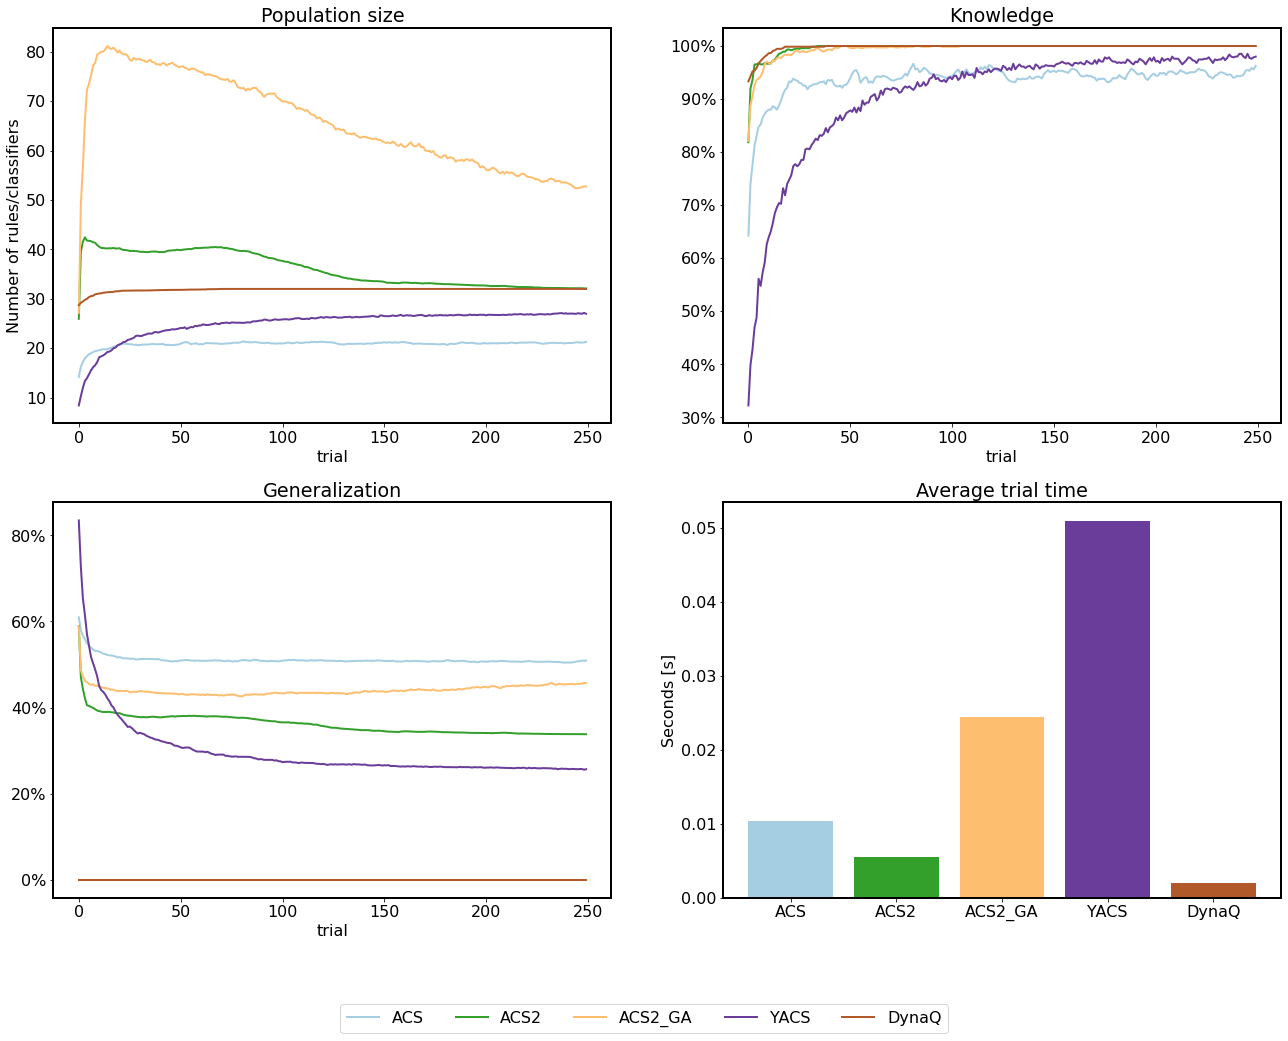

In [7]:
plot_comparison(simple_maze_metrics)
# plt.savefig('plots/simple-maze.png', transparent=False, bbox_inches='tight')

## Corridor

![corridor](img/corridor.png)

In [8]:


corridor = gym.make('corridor-20-v0')

# LCS helpers
def corridor_knowledge(pop, env):
    transitions = env.env.get_transitions()
    reliable = [c for c in pop if c.is_reliable()]
    nr_correct = 0

    for start, action, end in transitions:
        p0 = Perception((str(start),))
        p1 = Perception((str(end),))

        if any(
            [True for cl in reliable if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1

    return nr_correct / len(transitions)


def corridor_metrics_collect(agent, env):
    population = agent.population
    return {
        'pop': len(population),
        'knowledge': corridor_knowledge(population, env),
        'generalization': generalization_score(population)
    }

class CorridorObservationWrapper(gym.ObservationWrapper):
    def observation(self, observation):
        return observation,


# DynaQ helpers
def dynaq_corridor_knowledge_calculator(model, env):
    transitions = env.env.get_transitions()
    nr_correct = 0

    for (s0, a, s1) in transitions:
        if s0 in model and a in model[s0] and model[s0][a][0] == s1:
            nr_correct += 1

    return nr_correct / len(transitions)

In [9]:
%%time

common_params = {
    'env': corridor,
    'observation_wrapper': CorridorObservationWrapper,
    'classifier_length': 1,
    'possible_actions': 2,
    'learning_rate': 0.1,
    'metrics_trial_freq': 1,
    'metrics_fcn': corridor_metrics_collect,
    'explore_trials': 300
}

yacs_params = {
    'trace_length': 3,
    'estimate_expected_improvements': False,
    'feature_possible_values': [set(str(i) for i in range(19)),]
}

dynaq_params = {
    'num_states': corridor.env.observation_space.n,
    'perception_to_state_mapper': lambda p: int(p),
    'knowledge_fcn': dynaq_corridor_knowledge_calculator
}

corridor_metrics = get_from_cache_or_run(
    f'{cache_prefix}/Corridor.dill', 
    lambda: avg_experiments(lambda: run_experiment_parallel(common_params, yacs_params=yacs_params, dynaq_params=dynaq_params), n=50))

corridor_metrics

CPU times: user 1.05 ms, sys: 198 µs, total: 1.24 ms
Wall time: 934 µs


time  knowledge  population  generalization  trial_steps
agent trial                                                              
acs   0      0.013263   0.030811       25.00        0.124395          NaN
      1      0.008309   0.044324       29.24        0.079523          NaN
      2      0.007750   0.060000       31.08        0.070115          NaN
      3      0.005127   0.065405       32.78        0.064128          NaN
      4      0.005064   0.069189       33.74        0.062289          NaN
...               ...        ...         ...             ...          ...
yacs  295    0.053470   1.000000       38.00        0.000000          NaN
      296    0.061020   1.000000       38.00        0.000000          NaN
      297    0.059495   1.000000       38.00        0.000000          NaN
      298    0.054383   1.000000       38.00        0.000000          NaN
      299    0.054448   1.000000       38.00        0.000000          NaN

[1500 rows x 5 columns]

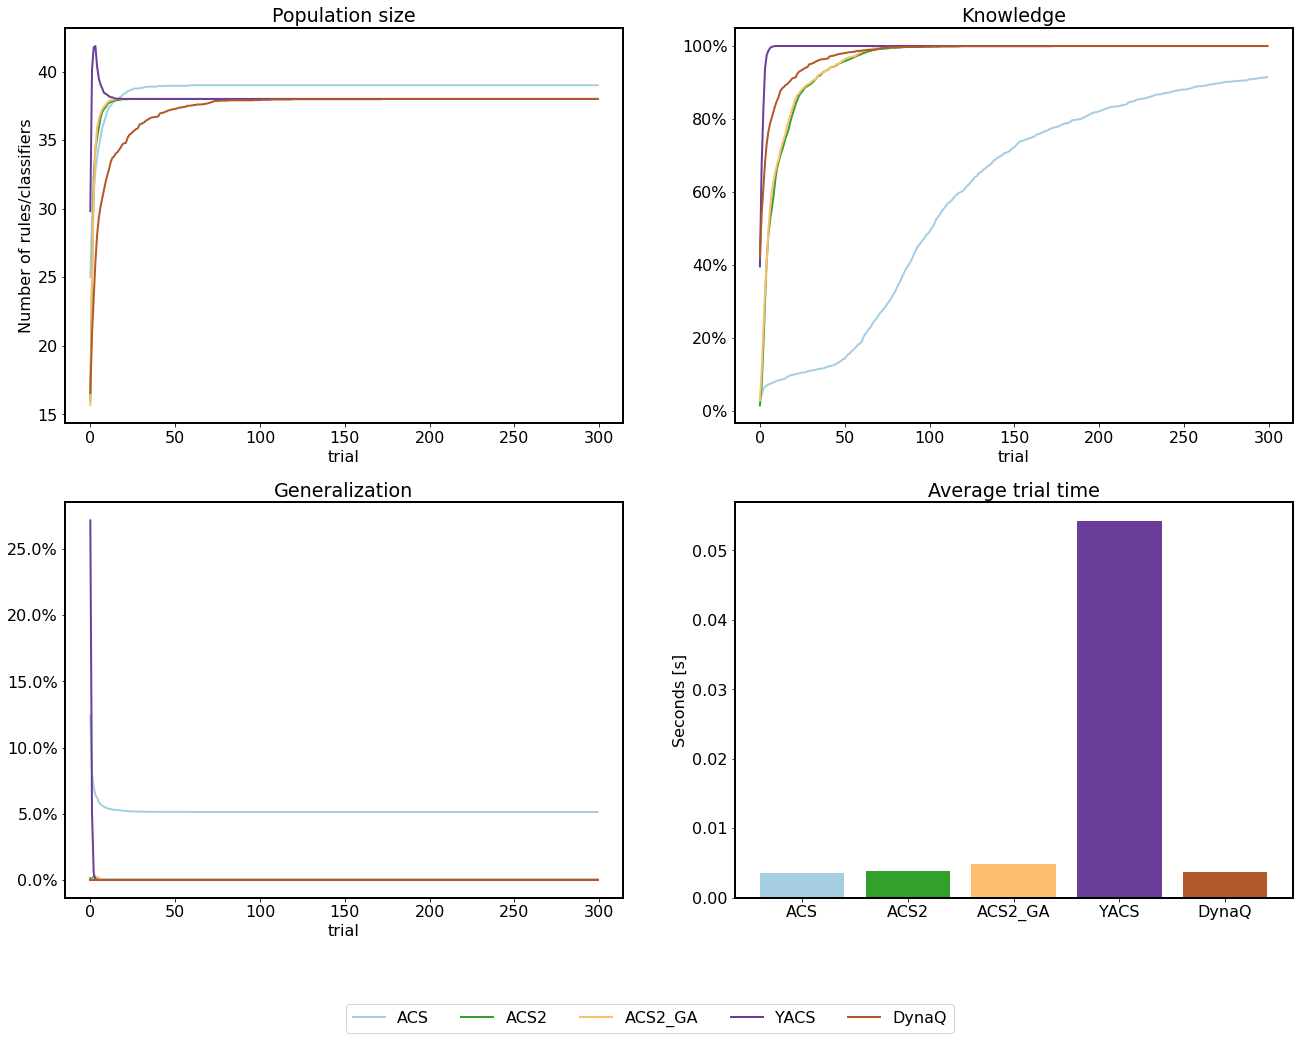

In [10]:
plot_comparison(corridor_metrics)
#plt.savefig('plots/corridor.png', transparent=False, bbox_inches='tight')

## Grid
![grid](img/grid.png)

In [11]:


grid = gym.make('grid-20-v0')
grid_transitions = grid.env._transitions

unique_states = set()
for (s0, a, s1) in grid_transitions:
    unique_states.add(s0)
    unique_states.add(s1)

grid_state_mapping = {idx: s for idx, s in enumerate(unique_states)}


# LCS helpers
def grid_knowledge(population, env):
    transitions = env.env.get_transitions()
    reliable = [c for c in population if c.is_reliable()]
    nr_correct = 0
    
    for start, action, end in transitions:
        p0 = Perception([str(el) for el in start])
        p1 = Perception([str(el) for el in end])
        
        if any([True for cl in reliable if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1
    
    return nr_correct / len(transitions)

def grid_metrics_collector(agent, env):
    population = agent.population
    return {
        'pop': len(population),
        'knowledge': grid_knowledge(population, env),
        'generalization': generalization_score(population)
    }

# DynaQ helpers
def grid_perception_to_int(p0):
    p0m = tuple(map(int, p0))
    return list(grid_state_mapping.keys())[list(grid_state_mapping.values()).index(p0m)]

def dynaq_grid_knowledge_calculator(model, env):
    all_transitions = 0
    nr_correct = 0

    for p0, a, p1 in grid_transitions:
        s0 = grid_perception_to_int(p0)
        s1 = grid_perception_to_int(p1)

        all_transitions += 1
        if s0 in model and a in model[s0] and model[s0][a][0] == s1:
            nr_correct += 1

    return nr_correct / all_transitions

In [12]:
%%time

common_params = {
    'env': grid,
    'observation_wrapper': None,
    'classifier_length': 2,
    'possible_actions': 4,
    'learning_rate': 0.1,
    'metrics_trial_freq': 1,
    'metrics_fcn': grid_metrics_collector,
    'explore_trials': 250
}

yacs_params = {
    'trace_length': 3,
    'estimate_expected_improvements': False,
    'feature_possible_values': [
        set(str(i) for i in range(20)),
        set(str(i) for i in range(20))
    ]
}

dynaq_params = {
    'num_states': len(grid_state_mapping),
    'perception_to_state_mapper': grid_perception_to_int,
    'knowledge_fcn': dynaq_grid_knowledge_calculator
}

grid_metrics = get_from_cache_or_run(
    f'{cache_prefix}/Grid.dill', 
    lambda: avg_experiments(lambda: run_experiment_parallel(common_params, yacs_params=yacs_params, dynaq_params=dynaq_params), n=25))

grid_metrics

CPU times: user 1.27 ms, sys: 192 µs, total: 1.46 ms
Wall time: 1.49 ms


time  knowledge  population  generalization  trial_steps
agent trial                                                               
acs   0       0.374379   0.147115       62.40        0.533534          NaN
      1       0.207748   0.218235       69.04        0.529913          NaN
      2       0.454148   0.349223       74.96        0.526801          NaN
      3       0.466074   0.467589       76.08        0.526337          NaN
      4       0.389117   0.557128       76.40        0.526219          NaN
...                ...        ...         ...             ...          ...
yacs  245    12.542294   0.947879      765.16        0.056866          NaN
      246     9.046828   0.947879      765.16        0.056866          NaN
      247     5.285591   0.947879      765.16        0.056866          NaN
      248     8.762453   0.947879      765.16        0.056866          NaN
      249    11.708679   0.947958      765.32        0.056915          NaN

[1250 rows x 5 columns]

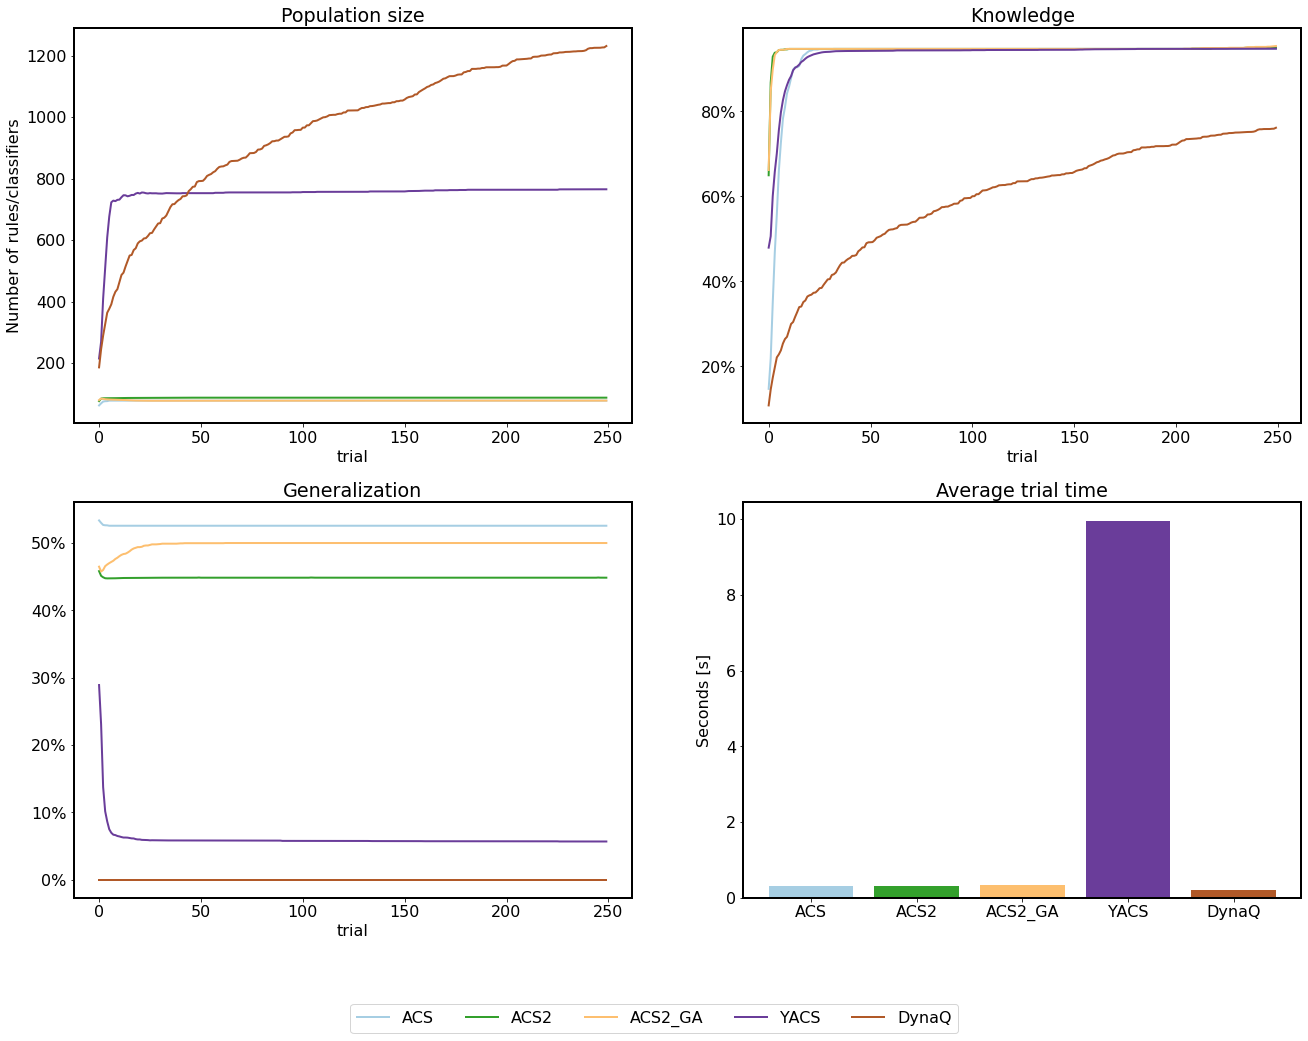

In [13]:
plot_comparison(grid_metrics)
#plt.savefig('plots/grid.png', transparent=False, bbox_inches='tight')

## rMPX

In [14]:
RMPX_SIZE = 3
RMPX_BINS = 10
rmpx = gym.make(f'real-multiplexer-{RMPX_SIZE}bit-v0')

_range, _low = (rmpx.observation_space.high - rmpx.observation_space.low, rmpx.observation_space.low)

RMPX_STEP = _range / RMPX_BINS

In [15]:
import itertools
import bitstring

class RealMultiplexerUtils:
    def __init__(self, size, ctrl_bits, bins, _range, _threshold=0.5):
        self._size = size
        self._ctrl_bits = ctrl_bits
        self._bins = bins
        self._step = _range / bins
        self._threshold = _threshold

        self._attribute_values = [list(range(0, bins))] * (size) + [[0, bins]]
        self._input_space = itertools.product(*self._attribute_values)
        self.state_mapping = {idx: s for idx, s in enumerate(self._input_space)}
        self.state_mapping_inv = {v: k for k, v in self.state_mapping.items()}

    def discretize(self, obs, _type=int):
        r = (obs + np.abs(_low)) / _range
        b = (r * RMPX_BINS).astype(int)
        return b.astype(_type).tolist()

    def reverse_discretize(self, discretized):
        return discretized * self._step[:len(discretized)]
    
    def get_transitions(self):
        transitions = []

        initial_dstates = [list(range(0, self._bins))] * (self._size)
        for d_state in itertools.product(*initial_dstates):
            correct_answer = self._get_correct_answer(d_state)

            if correct_answer == 0:
                transitions.append((d_state + (0,), 0, d_state + (self._bins,)))
                transitions.append((d_state + (0,), 1, d_state + (0,)))
            else:
                transitions.append((d_state + (0,), 0, d_state + (0,)))
                transitions.append((d_state + (0,), 1, d_state + (self._bins,)))

        return transitions

    def _get_correct_answer(self, discretized):
        estimated_obs = self.reverse_discretize(discretized)
        # B = np.where(estimated_obs > self._threshold, 1, 0)
        bits = bitstring.BitArray(estimated_obs > self._threshold)
        _ctrl_bits = bits[:self._ctrl_bits]
        _data_bits = bits[self._ctrl_bits:]

        return int(_data_bits[_ctrl_bits.uint])

In [16]:
rmpx_utils = RealMultiplexerUtils(RMPX_SIZE, 1, RMPX_BINS, _range)
print(f"Possible states: {len(rmpx_utils.state_mapping)}")

class DiscretizedWrapper(gym.ObservationWrapper):
    def observation(self, obs):
        return rmpx_utils.discretize(obs, _type=str)

def rmpx_knowledge(population, env):
    reliable = [c for c in population if c.is_reliable()]
    nr_correct = 0
    
    for start, action, end in rmpx_utils.get_transitions():
        p0 = Perception([str(el) for el in start])
        p1 = Perception([str(el) for el in end])
        
        if any([True for cl in reliable if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1
    
    return nr_correct / len(rmpx_utils.get_transitions())

def rmpx_metrics_collector(agent, env):
    population = agent.population
    return {
        'pop': len(population),
        'knowledge': rmpx_knowledge(population, env),
        'generalization': generalization_score(population)
    }

# DynaQ helpers
def rmpx_perception_to_int(p0, discretize=True):
    if discretize:
        p0 = rmpx_utils.discretize(p0)
        
    return rmpx_utils.state_mapping_inv[tuple(p0)]

def dynaq_rmpx_knowledge_calculator(model, env):
    all_transitions = 0
    nr_correct = 0

    for p0, a, p1 in rmpx_utils.get_transitions():
        s0 = rmpx_perception_to_int(p0, discretize=False)
        s1 = rmpx_perception_to_int(p1, discretize=False)

        all_transitions += 1
        if s0 in model and a in model[s0] and model[s0][a][0] == s1:
            nr_correct += 1

    return nr_correct / len(rmpx_utils.get_transitions())

Possible states: 2000


Knowledge calculation (creating transition matrix):
1. Generate all posible discretized states (with `0` at the end)
2. For each such a state estimate original perception (multiply by step size)
3. For each estimated perception obtain correct answer
4. For each estimate perception create two rows in transition matrix - for good and wrong answer. 


In [17]:
%%time

common_params = {
    'env': rmpx,
    'observation_wrapper': DiscretizedWrapper,
    'classifier_length': RMPX_SIZE+1,
    'possible_actions': 2,
    'learning_rate': 0.1,
    'metrics_trial_freq': 100,
    'metrics_fcn': rmpx_metrics_collector,
    'explore_trials': 15_000
}

yacs_params = {
    'trace_length': 3,
    'estimate_expected_improvements': False,
    'feature_possible_values': [{str(i) for i in range(RMPX_BINS)}] * RMPX_SIZE + [{'0', '10'}]
}

dynaq_params = {
    'num_states': len(rmpx_utils.state_mapping),
    'perception_to_state_mapper': rmpx_perception_to_int,
    'knowledge_fcn': dynaq_rmpx_knowledge_calculator
}

rmpx_metrics = get_from_cache_or_run(
    f'{cache_prefix}/rmpx.dill', 
    lambda: avg_experiments(lambda: run_experiment_parallel(common_params, yacs_params=yacs_params, dynaq_params=dynaq_params), n=5))

rmpx_metrics

CPU times: user 1.6 ms, sys: 0 ns, total: 1.6 ms
Wall time: 1.67 ms


time  knowledge  population  generalization  trial_steps
agent trial                                                              
acs   0      0.002597     0.0000         2.6        0.950000          NaN
      100    0.000268     0.0000         4.0        0.875000          NaN
      200    0.000345     0.0000         4.0        0.875000          NaN
      300    0.000290     0.0000         4.0        0.875000          NaN
      400    0.000278     0.0000         4.0        0.875000          NaN
...               ...        ...         ...             ...          ...
yacs  14500  0.012874     0.9748      1253.8        0.083252          NaN
      14600  0.012796     0.9751      1253.4        0.083399          NaN
      14700  0.013754     0.9765      1256.6        0.083266          NaN
      14800  0.012902     0.9774      1255.2        0.083259          NaN
      14900  0.013099     0.9778      1253.2        0.083278          NaN

[750 rows x 5 columns]

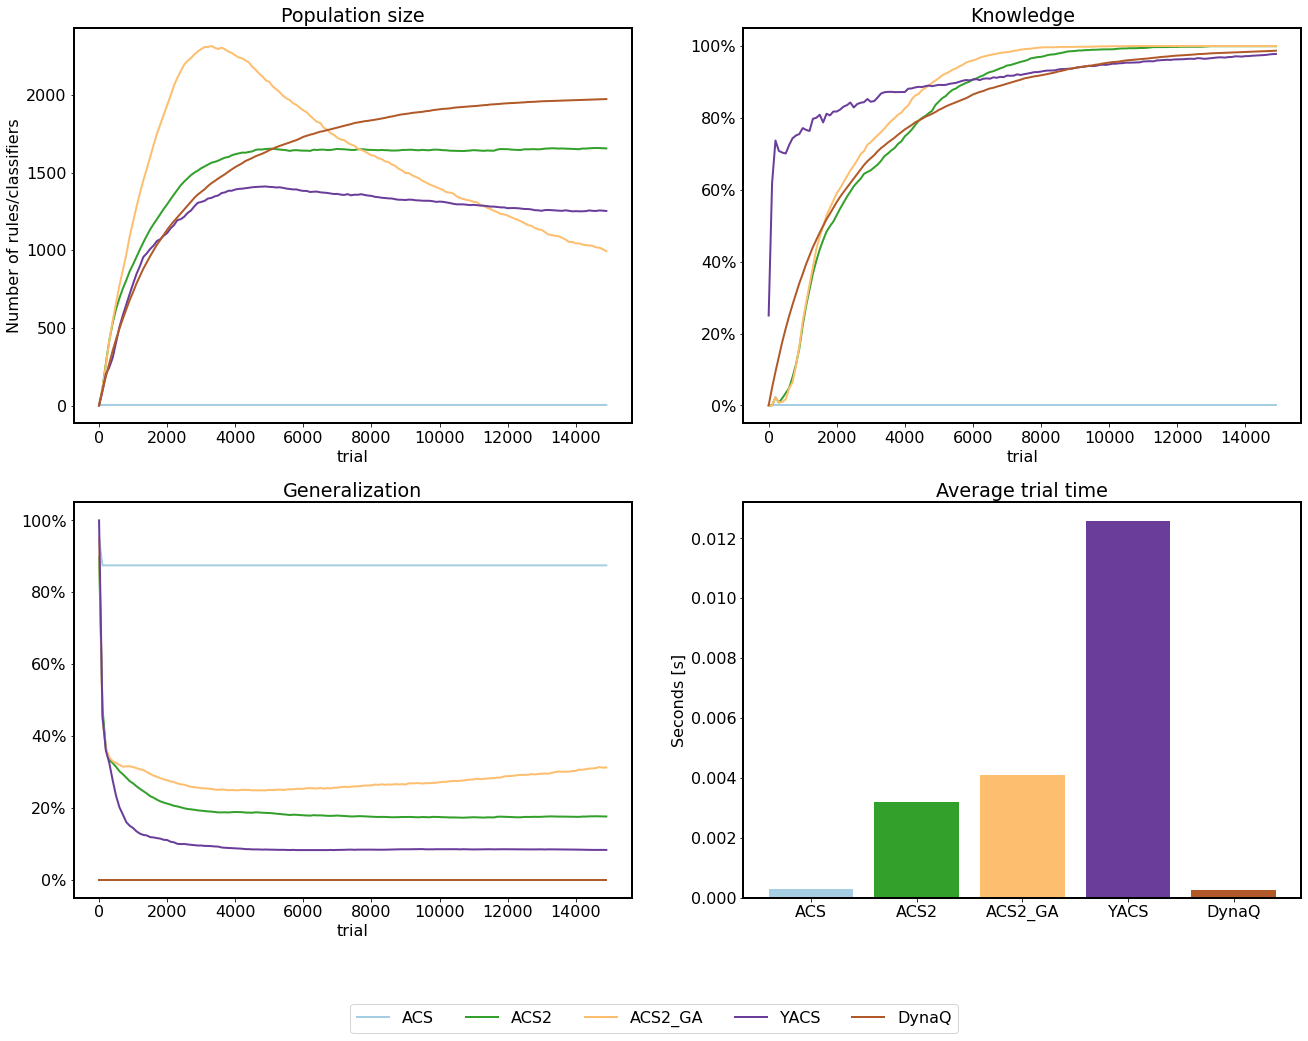

In [18]:
plot_comparison(rmpx_metrics)
#plt.savefig('plots/rmpx.png', transparent=False, bbox_inches='tight')

## Conclusions

First obvious points:
- YACS is over-specialising and slow,
- YACS handles big dimensions (Grid environment) poorly